Code adapted from: https://www.kaggle.com/code/nnsssadithya/esrgan-enhanced-super-resolution-gan/notebook

In [124]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [143]:
# Set paths
kaggle_image_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
kaggle_code_path = kagglehub.model_download("kaggle/esrgan-tf2/tensorFlow2/esrgan-tf2")

In [126]:
import os

# Check where the dataset was downloaded
print("Dataset contents:")
print(os.listdir(kaggle_image_path))

# Check where the model was downloaded
print("Model contents:")
print(os.listdir(kaggle_code_path))

Dataset contents:
['Testing', 'Training']
Model contents:
['variables', 'saved_model.pb']


In [127]:
# Declaring Constants
# Download dataset
import kagglehub

IMAGE_PATH = os.path.join(kaggle_image_path, 'Testing', 'glioma', 'Te-gl_0024.jpg')  # Replace with the exact path
SAVED_MODEL_PATH = kaggle_code_path

In [128]:
# Preprocess the image for input
def preprocess_image(image_path):
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [129]:
# Display the original and super-resolved images

%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [130]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


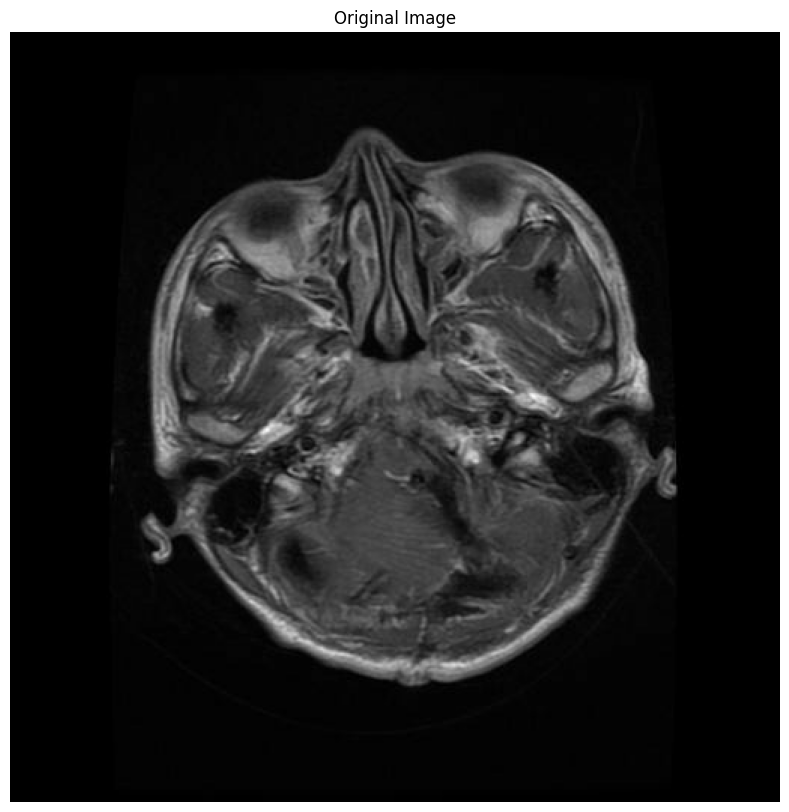

In [131]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [132]:
model = hub.load(SAVED_MODEL_PATH)

In [133]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 74.709636


Saved as Super Resolution.jpg


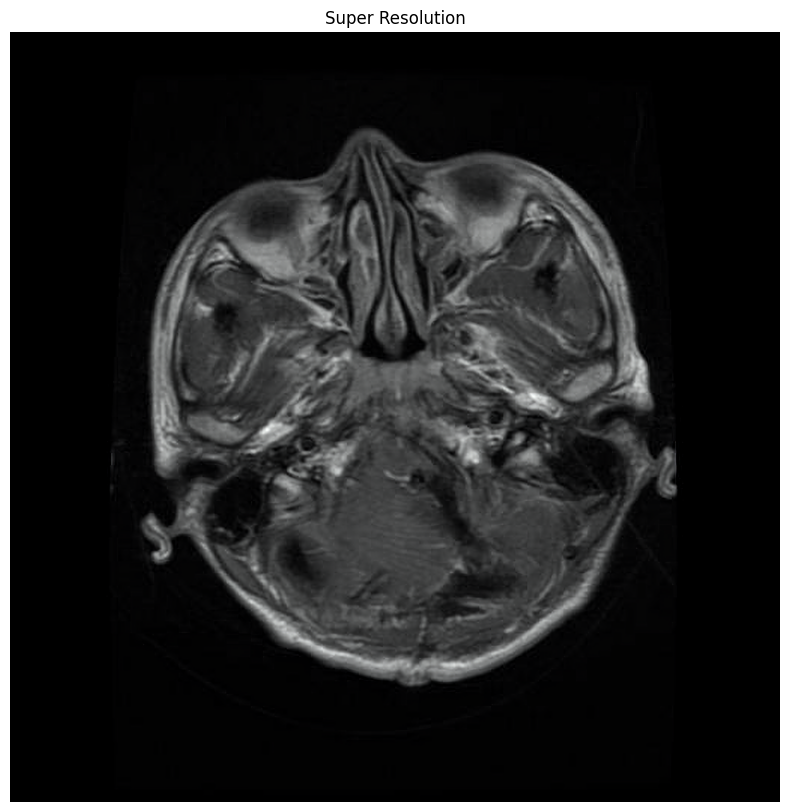

In [134]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [135]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [136]:
hr_image = preprocess_image(IMAGE_PATH)

In [137]:
lr_image = downscale_image(tf.squeeze(hr_image))


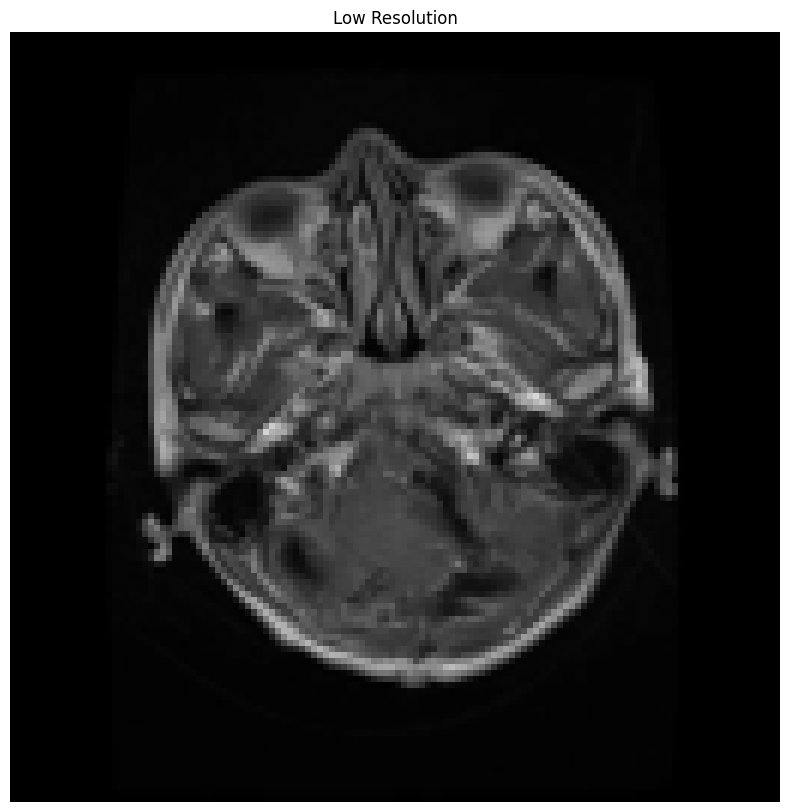

In [138]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [139]:
model = hub.load(SAVED_MODEL_PATH)

In [140]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 6.409185


PSNR Achieved: 33.168335


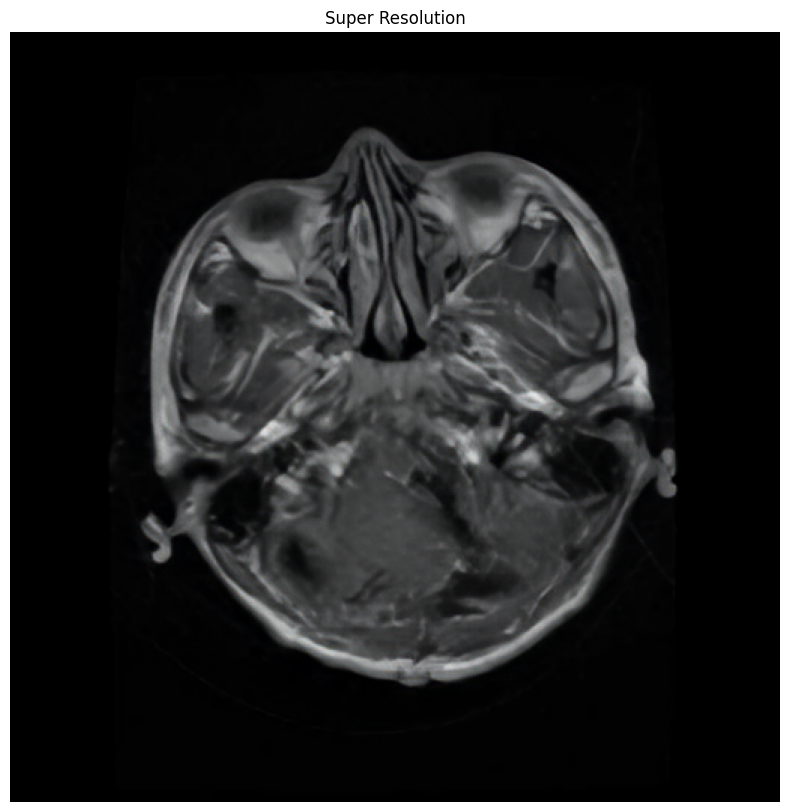

In [141]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 33.168335


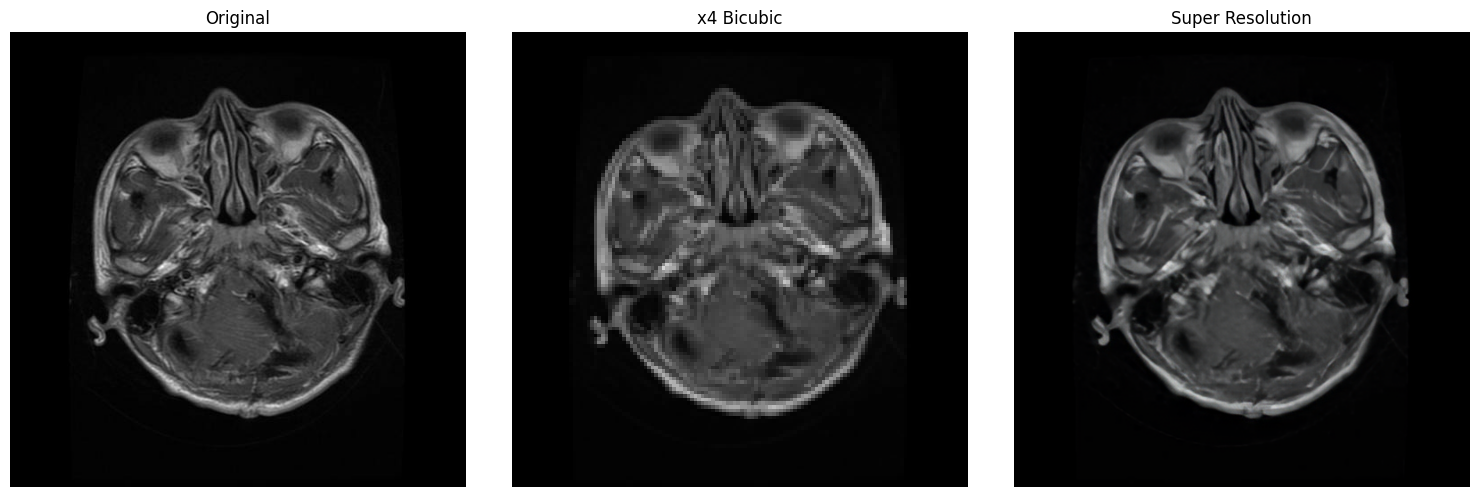

In [142]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)